In [320]:
!pip3 install pandas matplotlib seaborn sklearn xgboost lightgbm networkx

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://mirrors.cloud.aliyuncs.com/pypi/simple/
     |████████████████████████████████| 1.6 MB 7.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Part1 赛题背景

提高中小商家的数字化经营能力，是我国数字经济做强做优做大的关键基础，也是推动数字技术与实体经济深度融合的关键路径之一。中小商家通过分发数字消费券，提升其数字化经营的收益率和效率，是其数字化经营能力的重要标志之一，但同时也面临着长尾客户及消费券数量多、非结构化数据异质性强等挑战。本赛道围绕中小商家数字消费券分发这一关键问题，考察选手如何利用多种非结构化数据，如用户历史行为序列、用户间关系图、消费券知识图谱等，来帮助提高数字消费券的分发精度，从而提高中小商家的数字化经营能力。


## Part2 数据说明

本赛题会向选手提供一段时间内消费券向用户展示和被用户领取的数据，并要求选手预测在这段时间以后用户对消费券的领取行为。为了尽可能还原真实的工业数据环境，本赛题还会向选手提供用户和消费券的基础特征、用户间关系以及消费券知识图谱等数据，同时确保这些数据的采集和构造都是发生在待预测时间段之前。详细的数据说明如下：

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm
from lightgbm import LGBMClassifier 

In [22]:
train = pd.read_json('/home/admin/workspace/job/input/train.jsonl', lines=True)
user_feat = pd.read_csv('/home/admin/workspace/job/input/resources/user_feat.csv', )
item_feat = pd.read_csv('/home/admin/workspace/job/input/resources/item_feat.csv', )
uu_graph = pd.read_csv("/home/admin/workspace/job/input/resources/uu_graph.csv")
mkt_kg_graph = pd.read_csv('/home/admin/workspace/job/input/resources/mkt_kg_graph.csv', )
test = pd.read_json('/home/admin/workspace/job/input/test.jsonl', lines=True)

### 消费券展示/领取 (train)

包含一段时间内消费券向用户展示和被用户领取的数据，每行表示一次展示。

| **列名** | **涵义**                                                     |
| -------- | ------------------------------------------------------------ |
| id       | 仅作为数据的标识，内容为从 0 开始编号的索引值                |
| log_time | 展示时间索引，按展示时间戳从早到晚排序后，从 0 开始编号的索引值 |
| user_id  | 用户标识，从 0 开始编号的索引值                              |
| item_id  | 消费券标识，从 0 开始编号的索引值                            |
| label    | 本次展示的消费券被用户领取时为 1，否则为 0                   |
| dt       | 本次展示对应日期的天级相对时间（如 0 代表第一天的数据）      |

### 用户基础特征 (user_feat)

包含所有用户的基础特征，每行表示一位用户。

| **列名**   | **涵义**                                                     |
| ---------- | ------------------------------------------------------------ |
| user_id    | 用户标识，从 0 开始编号的索引值                              |
| gender     | 性别（含性别未知）                                           |
| age        | 年龄（已对实际年龄做分档处理）                               |
| occupation | 用户职业的索引                                               |
| entity_cnt | 用户历史行为的标签及频次，标签由业务专家产出，能反映用户的行为类型（例如喝咖啡、打车等）。标签经过脱敏处理为从 0 开始编号的索引值。 数据格式为 k1:v1,k2:v2,...,kn:vn，其中 ki 为标签标识, vi 为经过缩放处理的频次。 |

### 消费券基础特征 (item_feat)

包含所有消费券的基础特征，每行表示一张消费券。

| **列名**                     | **涵义**                                                     |
| ---------------------------- | ------------------------------------------------------------ |
| item_id                      | 消费券标识，从 0 开始编号的索引值                            |
| category_l1_name             | 消费券所属一级类目，从 0 开始编号的索引值                    |
| category_l2_name             | 消费券所属二级类目，从 0 开始编号的索引值                    |
| category_l3_name             | 消费券所属三级类目，从 0 开始编号的索引值                    |
| voucher_benefit_floor_amount | 消费券使用门槛，即使用时原订单需要支付的最低金额（满减优惠券），或商品原价格（商品优惠券）（单位：分）。 |
| voucher_benefit_amount       | 消费券优惠金额（单位：分）                                   |

### 用户间关系 (uu_graph)

包含上述用户间的社交关系，每行表示一个关系。

| **列名**      | **涵义**                                                |
| ------------- | ------------------------------------------------------- |
| left_user_id  | 用户标识，从 0 开始编号的索引值（与用户基础特征表对齐） |
| right_user_id | 用户标识，从 0 开始编号的索引值（与用户基础特征表对齐） |

### 消费券图谱 (mkt_kg_graph)

描述消费券与其他实体（小程序、商家、品牌）关联的知识图谱，每行表示图谱中的一条边。

| **列名**           | **涵义**                                                     |
| ------------------ | ------------------------------------------------------------ |
| source_entity_id   | 起始实体标识，每种类型实体的标识都是从 0 开始编号的索引值。其中消费券标识与消费券基础特征中的券 ID 为统一 ID 体系。 |
| target_entity_id   | 终止实体标识，每种类型实体的标识都是从 0 开始编号的索引值。其中消费券标识与消费券基础特征中的券 ID 为统一 ID 体系。 |
| source_entity_type | 起始实体类型，包括消费券、小程序、商家、品牌共 4 种类型实体  |
| target_entity_type | 终止实体类型，包括消费券、小程序、商家、品牌共 4 种类型实体  |

*注：实体类型+实体标识是知识图谱中每个节点的唯一标识。*

### A/B 榜测试数据 (test)

A/B  榜使用的测试数据是“消费券展示/领取”数据表中时间段之后发生的消费券展示记录，每行包含一个用户标识和一个消费券标识，表示向该用户展示了该消费券（相同的记录已去重），选手需要对每行数据进行预测，即预测该用户是否会领取该消费券。其中 A 榜和 B 榜会分别从中随机选取部分数据计算对应榜单的指标。

| **列名** | **涵义**                                      |
| -------- | --------------------------------------------- |
| id       | 仅作为数据的标识，内容为从 0 开始编号的索引值 |
| user_id  | 用户标识，从 0 开始编号的索引值               |
| item_id  | 消费券标识，从 0 开始编号的索引值             |

In [11]:
train.head(2)

,id,user_id,item_id,log_time,label,dt
0,0,41002,385,0,0,0
1,1,18880,18,1,0,0


In [10]:
train.describe().astype(int)

,id,user_id,item_id,log_time,label,dt
count,1043215,1043215,1043215,1043215,1043215,1043215
mean,521607,89344,628,519943,0,2
std,301150,52257,467,300224,0,1
min,0,0,0,0,0,0
25%,260803,44002,246,260183,0,1
50%,521607,89448,511,519765,0,2
75%,782410,134543,998,779962,0,4
max,1043214,180610,1695,1040174,1,5


In [12]:
user_feat.head(1)

,user_id,gender,age,occupation,entity_cnt
0,27948,1.0,2.0,19.0,"228:0.0,1230:0.6931471805599453,2369:0.0,282:4..."


In [15]:
user_feat.describe(include='all')

,user_id,gender,age,occupation,entity_cnt
count,180611.000000,180335.000000,180201.000000,93714.000000,180179
unique,NaN,NaN,NaN,NaN,179940
top,NaN,NaN,NaN,NaN,1075:0.6931471805599453
freq,NaN,NaN,NaN,NaN,36
mean,90305.000000,1.633881,2.025505,16.452974,NaN
std,52138.049072,0.482066,0.946319,5.791035,NaN
min,0.000000,0.000000,0.000000,0.000000,NaN
25%,45152.500000,1.000000,1.000000,11.000000,NaN
50%,90305.000000,2.000000,2.000000,19.000000,NaN
75%,135457.500000,2.000000,3.000000,19.000000,NaN


In [16]:
item_feat.head(1)

,item_id,category_l1_name,category_l2_name,category_l3_name,voucher_benefit_floor_amount,voucher_benefit_amount
0,385,5.0,38.0,128.0,19000.0,500.0


In [20]:
item_feat.describe(include='all')

,item_id,category_l1_name,category_l2_name,category_l3_name,voucher_benefit_floor_amount,voucher_benefit_amount
count,1716.000000,1613.000000,1613.000000,1613.000000,1693.000000,1712.000000
mean,857.500000,7.137632,24.436454,87.818971,4748.106320,6777.648949
std,495.510848,2.471355,13.556900,41.487174,37284.411981,20789.136088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,428.750000,8.000000,14.000000,50.000000,10.000000,50.000000
50%,857.500000,8.000000,25.000000,103.000000,10.000000,990.000000
75%,1286.250000,8.000000,31.000000,125.000000,2500.000000,3000.000000
max,1715.000000,9.000000,51.000000,156.000000,1000000.000000,306058.000000


In [24]:
uu_graph.head(1)

,left_user_id,right_user_id
0,86219,172571


In [25]:
mkt_kg_graph.head(1)

,source_entity_id,target_entity_id,source_entity_type,target_entity_type
0,141,8579,app,shop


In [26]:
test.head(1)

,id,user_id,item_id
0,0,24731,1099


## Part3 数据分析

In [32]:
user_feat.head(2)

,user_id,gender,age,occupation,entity_cnt
0,27948,1.0,2.0,19.0,"228:0.0,1230:0.6931471805599453,2369:0.0,282:4..."
1,36424,1.0,1.0,19.0,"231:1.0986122886681098,1075:1.6094379124341003..."


In [31]:
user_feat['gender'].value_counts()

2.0    114339
1.0     65968
0.0        28
Name: gender, dtype: int64

In [33]:
user_feat['age'].value_counts()

2.0    72510
1.0    57180
3.0    32578
4.0    16266
0.0     1667
Name: age, dtype: int64

In [54]:
user_feat.groupby('gender')['age'].value_counts(normalize=True).sort_index()

gender  age
1.0     0.0    0.011637
        1.0    0.299656
        2.0    0.403238
        3.0    0.179095
        4.0    0.106374
2.0     0.0    0.007875
        1.0    0.327494
        2.0    0.401892
        3.0    0.181763
        4.0    0.080977
Name: age, dtype: float64

In [53]:
user_feat.groupby('gender')['occupation'].value_counts(normalize=True).sort_index()

gender  occupation
0.0     11.0          0.750000
        19.0          0.250000
1.0     0.0           0.003548
        1.0           0.003775
        2.0           0.004286
        3.0           0.059777
        4.0           0.008827
        5.0           0.012574
        6.0           0.002413
        7.0           0.002299
        8.0           0.007891
        9.0           0.002640
        10.0          0.003832
        11.0          0.136414
        12.0          0.000681
        13.0          0.000823
        14.0          0.001987
        15.0          0.001930
        16.0          0.002782
        17.0          0.035452
        18.0          0.015782
        19.0          0.381567
        20.0          0.005648
        21.0          0.191053
        22.0          0.098635
        23.0          0.001221
        24.0          0.000341
        25.0          0.013823
2.0     0.0           0.002480
        1.0           0.002052
        2.0           0.015749
        3.0         

In [75]:
def user_feat_entity_cnt2json(x):
    try:
        x = x.split(',')
        return {int(xx.split(':')[0]):float(xx.split(':')[1]) for xx in x}
    except:
        return {}

In [77]:
user_feat['entity_cnt'] = user_feat['entity_cnt'].apply(user_feat_entity_cnt2json)

In [78]:
user_feat['entity_cnt']

0         {228: 0.0, 1230: 0.6931471805599453, 2369: 0.0...
1         {231: 1.0986122886681098, 1075: 1.609437912434...
2         {47: 0.6931471805599453, 63: 0.0, 134: 0.0, 57...
3         {63: 0.0, 165: 0.0, 228: 0.6931471805599453, 6...
4         {113: 0.0, 191: 0.6931471805599453, 245: 0.0, ...
                                ...                        
180606    {768: 0.0, 1230: 0.0, 1567: 0.6931471805599453...
180607    {194: 1.3862943611198906, 1899: 0.0, 2259: 0.0...
180608    {10: 0.0, 388: 1.6094379124341003, 907: 1.3862...
180609    {2172: 0.0, 968: 0.0, 2124: 1.3862943611198906...
180610    {228: 0.6931471805599453, 2369: 0.0, 2298: 3.1...
Name: entity_cnt, Length: 180611, dtype: object

In [85]:
train['label'].value_counts()

0    942230
1    100985
Name: label, dtype: int64

In [88]:
train = train.sort_values(by=['user_id', 'log_time'])

In [101]:
user_feat['user_id'].nunique(), train['user_id'].nunique(), test['user_id'].nunique()

(180611, 162706, 47911)

In [95]:
test['user_id'].nunique()

47911

In [104]:
# 不在训练集出现的，测试集用户
len(set(test['user_id'].unique()) - set(train['user_id'].unique()))

1933

In [105]:
# 在训练集出现的，测试集用户
len(set(test['user_id'].unique()) & set(train['user_id'].unique()))

45978

In [208]:
# 测试集平均每个用户拥有item_id
test.groupby('user_id')['item_id'].nunique().mean(), test.groupby('user_id')['item_id'].nunique().min()

(3.438166600571894, 1)

In [233]:
sum(test.groupby('user_id')['item_id'].nunique() == 1)

21950

In [154]:
# 训练集平均每个用户拥有item_id
train.groupby('user_id')['item_id'].nunique().mean()

5.538738583703121

In [165]:
len(set(test['item_id'].unique()) - set(train['item_id'].unique()))

58

In [108]:
train = pd.merge(train, user_feat, how='left')
train = pd.merge(train, item_feat, how='left')

In [110]:
test = pd.merge(test, user_feat, how='left')
test = pd.merge(test, item_feat, how='left')

In [112]:
train.head(2)

,id,user_id,item_id,log_time,label,dt,gender,age,occupation,entity_cnt,category_l1_name,category_l2_name,category_l3_name,voucher_benefit_floor_amount,voucher_benefit_amount
0,173397,0,543,173025,0,1,1.0,4.0,22.0,"{165: 0.6931471805599453, 170: 3.4965075614664...",8.0,29.0,45.0,10.0,2000.0
1,429729,0,385,428164,0,2,1.0,4.0,22.0,"{165: 0.6931471805599453, 170: 3.4965075614664...",5.0,38.0,128.0,19000.0,500.0


In [113]:
test.head(2)

,id,user_id,item_id,gender,age,occupation,entity_cnt,category_l1_name,category_l2_name,category_l3_name,voucher_benefit_floor_amount,voucher_benefit_amount
0,0,24731,1099,2.0,2.0,NaN,"{81: 0.0, 282: 1.3862943611198906, 287: 1.3862...",0.0,16.0,53.0,10.0,0.0
1,1,160029,1443,2.0,2.0,17.0,"{131: 0.6931471805599453, 300: 0.0, 674: 0.0, ...",8.0,50.0,6.0,500.0,380.0


In [114]:
train.corr()

,id,user_id,item_id,log_time,label,dt,gender,age,occupation,category_l1_name,category_l2_name,category_l3_name,voucher_benefit_floor_amount,voucher_benefit_amount
id,1.000000,-0.005055,0.048528,1.000000,0.002724,0.979626,-0.009439,-0.004917,-0.009023,-0.006095,-0.009209,-0.007666,-0.013394,0.013376
user_id,-0.005055,1.000000,-0.001529,-0.005057,-0.004463,-0.005734,0.023430,-0.000029,0.012495,0.001272,0.002149,-0.002462,0.000594,-0.005593
item_id,0.048528,-0.001529,1.000000,0.048525,-0.038559,0.044557,0.047024,-0.017821,-0.005821,0.150367,-0.020196,0.061440,-0.072113,0.117924
log_time,1.000000,-0.005057,0.048525,1.000000,0.002722,0.979686,-0.009444,-0.004906,-0.009021,-0.006110,-0.009219,-0.007664,-0.013393,0.013380
label,0.002724,-0.004463,-0.038559,0.002722,1.000000,0.000533,0.015357,-0.005680,-0.009069,-0.022109,-0.002377,0.000380,0.004613,-0.037776
dt,0.979626,-0.005734,0.044557,0.979686,0.000533,1.000000,-0.010862,0.005448,-0.005778,-0.013691,-0.007694,-0.010731,-0.012092,0.015757
gender,-0.009439,0.023430,0.047024,-0.009444,0.015357,-0.010862,1.000000,-0.064898,-0.058379,0.165949,-0.035876,-0.009753,-0.048805,0.038586
age,-0.004917,-0.000029,-0.017821,-0.004906,-0.005680,0.005448,-0.064898,1.000000,0.364688,-0.009778,0.036512,0.045674,0.063366,-0.052035
occupation,-0.009023,0.012495,-0.005821,-0.009021,-0.009069,-0.005778,-0.058379,0.364688,1.000000,-0.008612,0.010074,0.010206,0.021806,-0.022032
category_l1_name,-0.006095,0.001272,0.150367,-0.006110,-0.022109,-0.013691,0.165949,-0.009778,-0.008612,1.000000,0.034236,0.245016,-0.121978,0.158479


In [149]:
train.corr().loc['label'].abs().sort_values()

category_l3_name                0.000380
dt                              0.000533
category_l2_name                0.002377
log_time                        0.002722
id                              0.002724
user_id                         0.004463
voucher_benefit_floor_amount    0.004613
age                             0.005680
occupation                      0.009069
gender                          0.015357
category_l1_name                0.022109
voucher_benefit_amount          0.037776
item_id                         0.038559
label                           1.000000
Name: label, dtype: float64

<AxesSubplot:>

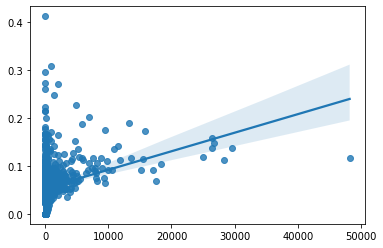

In [129]:
most_freq = train['item_id'].value_counts()[train['item_id'].value_counts() > 10]
label_mean = train.groupby(['item_id'])['label'].mean().loc[most_freq.index]

sns.regplot(x=most_freq.values, y=label_mean.values)
# 热门的item更加容易被下单

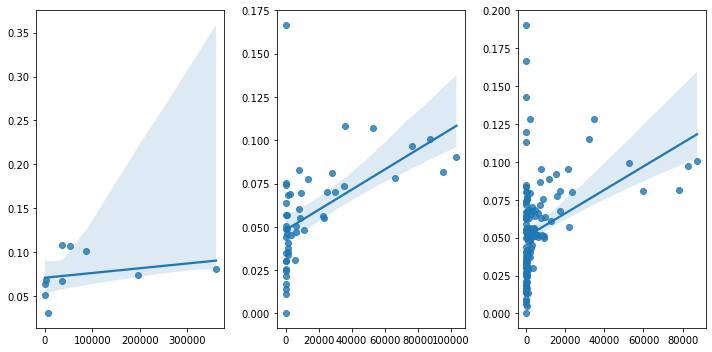

In [140]:
plt.figure(figsize=(10, 5))
most_freq = train['category_l1_name'].value_counts()[train['category_l1_name'].value_counts() > 10]
label_mean = train.groupby(['category_l1_name'])['label'].mean().loc[most_freq.index]
plt.subplot(131)
sns.regplot(x=most_freq.values, y=label_mean.values)

most_freq = train['category_l2_name'].value_counts()[train['category_l2_name'].value_counts() > 10]
label_mean = train.groupby(['category_l2_name'])['label'].mean().loc[most_freq.index]
plt.subplot(132)
sns.regplot(x=most_freq.values, y=label_mean.values)

most_freq = train['category_l3_name'].value_counts()[train['category_l3_name'].value_counts() > 10]
label_mean = train.groupby(['category_l3_name'])['label'].mean().loc[most_freq.index]
plt.subplot(133)
sns.regplot(x=most_freq.values, y=label_mean.values)

plt.tight_layout()

# 热门的category更加容易被下单

<AxesSubplot:>

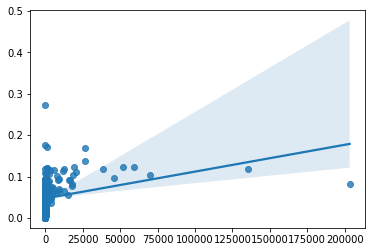

In [141]:
most_freq = train['voucher_benefit_amount'].value_counts()[train['voucher_benefit_amount'].value_counts() > 10]
label_mean = train.groupby(['voucher_benefit_amount'])['label'].mean().loc[most_freq.index]

sns.regplot(x=most_freq.values, y=label_mean.values)
# voucher_benefit_amount越大，更加容易被下单

<AxesSubplot:>

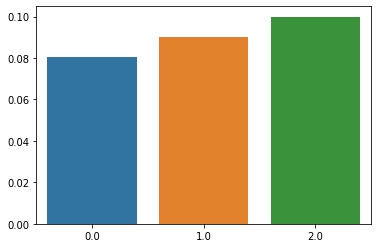

In [147]:
most_freq = train['gender'].value_counts()[train['gender'].value_counts() > 10]
label_mean = train.groupby(['gender'])['label'].mean().loc[most_freq.index]

sns.barplot(x=most_freq.index, y=label_mean.values)
# gender 与 下单概率存在一定关系

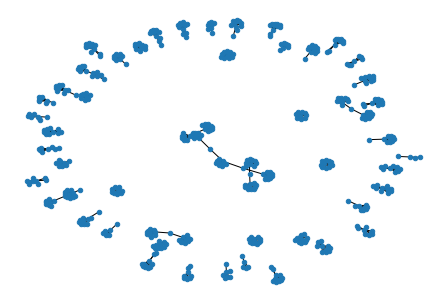

In [342]:
import networkx as nx
G = nx.Graph()

for idx in range(500):
    G.add_edge(uu_graph['left_user_id'].iloc[idx], uu_graph['right_user_id'].iloc[idx])
nx.draw(G, with_labels=False, font_weight='bold', node_size=20)

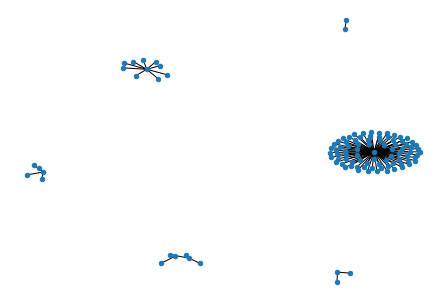

In [355]:
import networkx as nx
G = nx.Graph()

for idx in range(100):
    G.add_node(mkt_kg_graph['source_entity_id'].iloc[idx], 
               entity_type = mkt_kg_graph['source_entity_type'].iloc[idx])
    G.add_edge(mkt_kg_graph['source_entity_id'].iloc[idx], mkt_kg_graph['target_entity_id'].iloc[idx])

    
nx.draw(G, font_weight='bold', node_size=20,)

## Part4 特征工程

In [311]:
## 
train['item_id_freq'] = train['item_id'].map(train['item_id'].value_counts())
test['item_id_freq'] = test['item_id'].map(train['item_id'].value_counts())

train['item_id_target'] = train['item_id'].map(train.groupby(['item_id'])['label'].mean())
test['item_id_target'] = test['item_id'].map(train.groupby(['item_id'])['label'].mean())

## 
train['category_l1_freq'] = train['category_l1_name'].map(train['category_l1_name'].value_counts())
test['category_l1_freq'] = test['category_l1_name'].map(train['category_l1_name'].value_counts())

train['category_l1_target'] = train['category_l1_name'].map(train.groupby(['category_l1_name'])['label'].mean())
test['category_l1_target'] = test['category_l1_name'].map(train.groupby(['category_l1_name'])['label'].mean())

##
train['category_l2_freq'] = train['category_l2_name'].map(train['category_l2_name'].value_counts())
test['category_l2_freq'] = test['category_l2_name'].map(train['category_l2_name'].value_counts())

train['category_l2_target'] = train['category_l2_name'].map(train.groupby(['category_l2_name'])['label'].mean())
test['category_l2_target'] = test['category_l2_name'].map(train.groupby(['category_l2_name'])['label'].mean())

##
train['category_l3_freq'] = train['category_l3_name'].map(train['category_l3_name'].value_counts())
test['category_l3_freq'] = test['category_l3_name'].map(train['category_l3_name'].value_counts())

train['category_l3_target'] = train['category_l3_name'].map(train.groupby(['category_l3_name'])['label'].mean())
test['category_l3_target'] = test['category_l3_name'].map(train.groupby(['category_l3_name'])['label'].mean())

In [305]:
train['item_id'].map(train.groupby(['item_id'])['label'].mean())

0          0.075005
1          0.116020
2          0.090562
3          0.116020
4          0.110092
             ...   
1043210    0.123769
1043211    0.110240
1043212    0.082492
1043213    0.078318
1043214    0.116020
Name: item_id, Length: 1043215, dtype: float64

## Part5 训练与验证

- GAUC评价指标的定义
- 数据划分方法，需要考虑用户、时间、和记录

In [306]:
def gauc(val_pred):
    '''
    val_pred: 'user_id', 'item_id', 'label', 'pred'
    '''
    
    user_auc = []
    for df in val_pred.groupby('user_id'):
        try:
            score = roc_auc_score(df[1]['label'], df[1]['proba'])
            user_auc.append([score, df[1].shape[0]])
        except:
            pass

    user_auc = pd.DataFrame(user_auc)
    user_auc = (user_auc[0] * user_auc[1]).sum() / user_auc[1].sum()

    item_auc = []
    for df in val_pred.groupby('item_id'):
        try:
            score = roc_auc_score(df[1]['label'], df[1]['proba'])
            item_auc.append([score, df[1].shape[0]])
        except:
            pass

    item_auc = pd.DataFrame(item_auc)
    item_auc = (item_auc[0] * item_auc[1]).sum() / item_auc[1].sum()
    
    return user_auc, item_auc, (user_auc + item_auc) / 2

In [312]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

user_kf = KFold(n_splits=10, shuffle=True, random_state=123)
train_unique_users = train['user_id'].unique()

feature_name = [
    'gender', 'age', 'occupation', 
    'category_l1_name', 'category_l2_name', 'category_l3_name', 
    'voucher_benefit_floor_amount', 'voucher_benefit_amount',
    
    'item_id_freq', 'item_id_target',
    'category_l1_freq', 'category_l1_target',
    'category_l2_freq', 'category_l2_target',
    'category_l3_freq', 'category_l3_target'
]

for user_train_idx, user_val_idx in user_kf.split(train_unique_users, train_unique_users):
    user_train = train_unique_users[user_train_idx]
    user_val = train_unique_users[user_val_idx]
    
    # 验证集选择用户最后的3条记录
    val_idx = train[train['user_id'].isin(user_val)].groupby('user_id').tail(3).index
    train_idx = [x for x in train.index if x not in train_val_idx]
    
    print(train.iloc[train_idx].shape, train.iloc[val_idx].shape)
    break

(1005761, 23) (37454, 23)


In [313]:
model = LGBMClassifier(max_depth=5)
model.fit(train.iloc[train_idx][feature_name], train.iloc[train_idx]['label'],
         categorical_feature=['occupation', 'category_l1_name'])

/home/f17g5vivd4/.local/lib/python3.6/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(max_depth=5)

In [314]:
val_pred = train.iloc[train_val_idx][['user_id', 'item_id', 'label']].copy()
val_pred['proba'] = model.predict_proba(train.iloc[val_idx][feature_name])[:, 1]

In [315]:
gauc(val_pred)

(0.5912132352941176, 0.5357119305002072, 0.5634625828971624)